In [1]:
import wfdb
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import ast
import os
import json

In [2]:
# imports for filtering

from scipy.signal import butter, lfilter, iirnotch, filtfilt
from scipy.signal import find_peaks

### Code for reading a single signal:

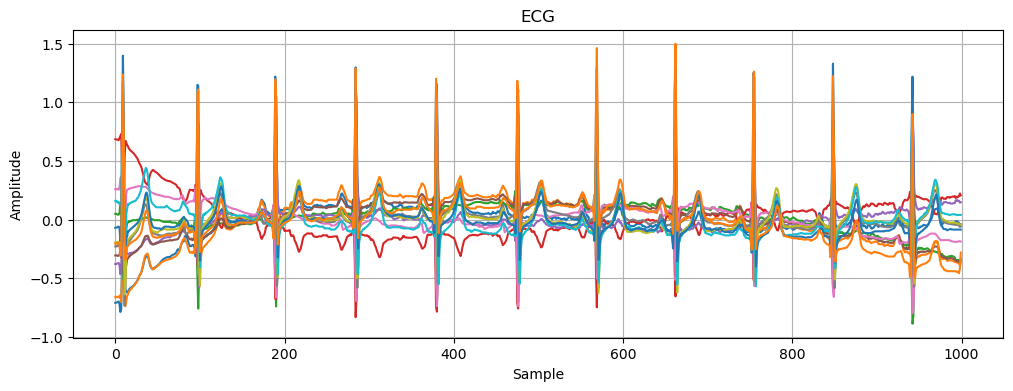

In [3]:
# Specify the path to your WFDB signal file (e.g., '01000_lr.dat')
signal_file = '01000_lr'

# Use wfdb.rdrecord() to read the signal file
record = wfdb.rdrecord(signal_file)

# Access the signal data and metadata
signal_data = record.p_signal  # NumPy array containing signal data
signal_metadata = record.__dict__  # Dictionary containing metadata

# You can access various metadata properties like sampling frequency, units, etc.
fs = record.fs  # Sampling frequency

# Visualize the signal
plt.figure(figsize=(12, 4))
plt.plot(signal_data)
plt.title('ECG')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

In [ ]:
signal_data.shape # 12 different signals from each lead and each signal has 1000 samples. 

### Filtering of a single signal
#### - Şimal'in eklediği kısım

RR Intervals:
[0.89 0.92 0.94 0.96 0.96 0.93 0.93 0.93 0.93 0.94]
Heart Rates:
[67.41573034 65.2173913  63.82978723 62.5        62.5        64.51612903
 64.51612903 64.51612903 64.51612903 63.82978723]
Average Heart Rate: 64.33572122385439 BPM


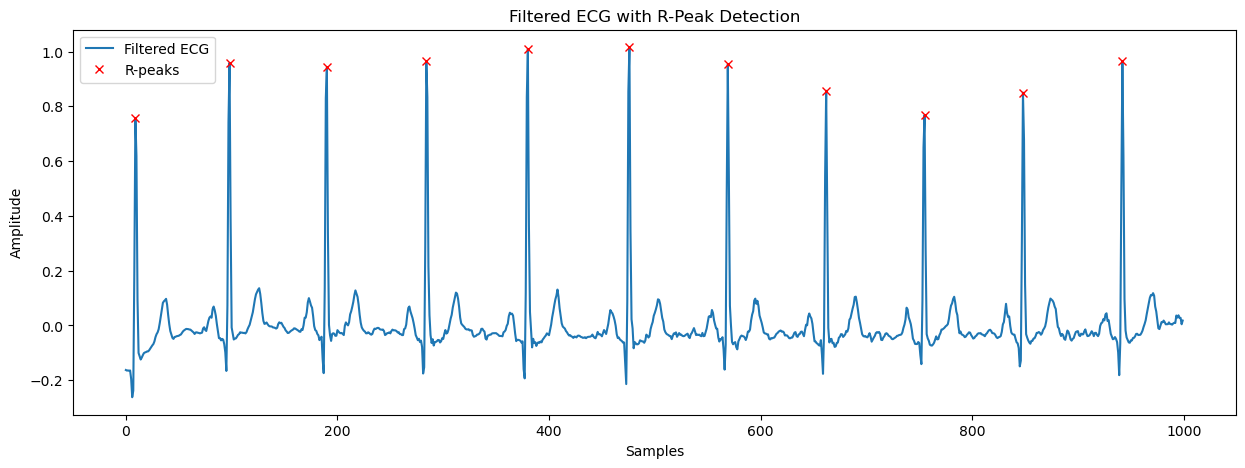

In [4]:
# Example: Filtering the ECG signal (Lead I)
ecg_lead = signal_data[:, 0]  # Assuming Lead I is the first column

# High-pass filter to remove baseline wander
b, a = butter(1, 0.5/(0.5*fs), btype='highpass')
filtered_ecg = filtfilt(b, a, ecg_lead)

# R-peak detection
r_peaks, _ = find_peaks(filtered_ecg, height=np.max(filtered_ecg)*0.5, distance=fs*0.6)
rr_intervals = np.diff(r_peaks) / fs  # dividing by sampling frequency to get time in seconds
print("RR Intervals:")
print(rr_intervals)

heart_rate = 60 / rr_intervals  # BPM
print("Heart Rates:")
print(heart_rate)

average_heart_rate = np.mean(heart_rate)

print(f"Average Heart Rate: {average_heart_rate} BPM")
# Visualize filtered signal with R-peaks
plt.figure(figsize=(15, 5))
plt.plot(filtered_ecg, label='Filtered ECG')
plt.plot(r_peaks, filtered_ecg[r_peaks], 'rx', label='R-peaks')
plt.title('Filtered ECG with R-Peak Detection')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

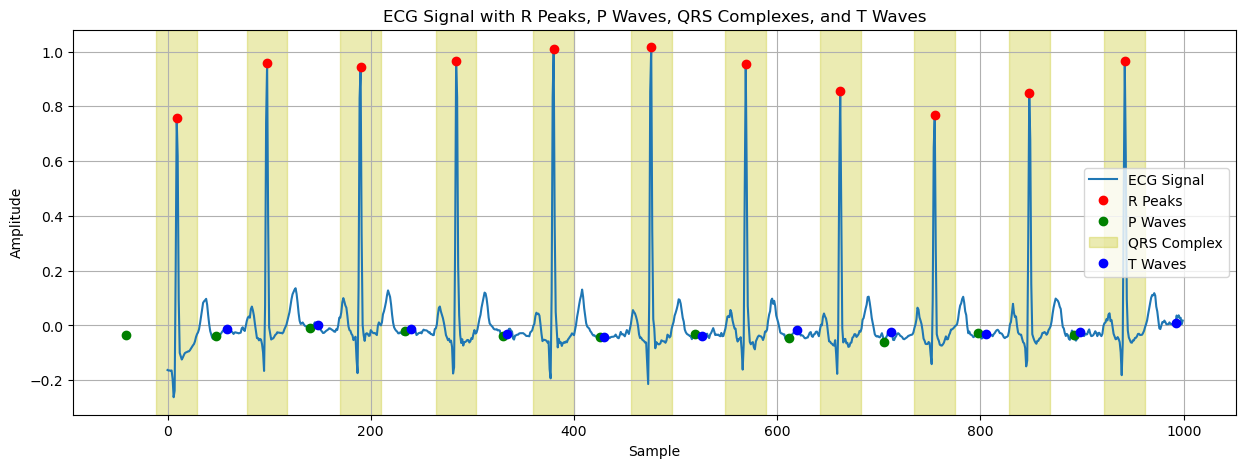

In [5]:
# Sample ECG data - replace with your actual data

# Sample indices for P waves, QRS complexes, and T waves - replace with actual indices
p_waves = r_peaks - 50  # Example P wave indices
qrs_start = r_peaks - 20  # Example start of QRS complex
qrs_end = r_peaks + 20   # Example end of QRS complex
t_waves = r_peaks + 50  # Example T wave indices

# Plotting
plt.figure(figsize=(15, 5))
plt.plot(filtered_ecg, label='ECG Signal')

# Mark R peaks
plt.plot(r_peaks, filtered_ecg[r_peaks], 'ro', label='R Peaks')

# Mark P waves
plt.plot(p_waves, filtered_ecg[p_waves], 'go', label='P Waves')

# Mark QRS complexes
for start, end in zip(qrs_start, qrs_end):
    plt.axvspan(start, end, color='y', alpha=0.3, label='QRS Complex' if start == qrs_start[0] else "")

# Mark T waves
plt.plot(t_waves, filtered_ecg[t_waves], 'bo', label='T Waves')

plt.title('ECG Signal with R Peaks, P Waves, QRS Complexes, and T Waves')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


### Code for reading multiple signals:

In [106]:
def load_raw_data(df, sampling_rate, path):
    data = []
    labels =[]
    
    
    warning_issued = False  # flag to track if a warning has been issued
    
    if sampling_rate == 100:
        filenames = df.filename_lr
    else:
        filenames = df.filename_hr
    
    
    for f in filenames:
        
        # Append file extensions for both .hea and .dat files
        file_path_dat = os.path.join(path, f + '.dat')
        file_path_hea = os.path.join(path, f + '.hea')
        
        # Check if both files exist
        if os.path.exists(file_path_dat) and os.path.exists(file_path_hea):
            signal, meta = wfdb.rdsamp(os.path.join(path, f), channels=[1])
            data.append(signal)
            #labels.append(df[df_column][i])
            
        else:
            if not warning_issued:
                print("Warning: One or more files do not exist. Further missing files will not be reported.")
                warning_issued = True
        
    
    if not data:
        print("No valid data found.")
        return None
    
    
    data = np.array(data)
    return data, labels

sampling_rate=100

# load and convert annotation data
Y = pd.read_csv('ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

### We need to create records100\00000\ folders in order to read multiple signals using Y 
#### - check filename_lr column of Y

In [107]:
# Y dataframe stores the address of each signal in the filename_lr column but we need to change the format of the address (for Windows)
Y['filename_lr'] = Y['filename_lr'].str.replace('/', '\\')

In [108]:
# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv('scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# apply aggregate_diagnostic function to Y.scp_codes column
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [97]:
Y.diagnostic_superclass.value_counts()

[NORM]                 9097
[MI]                   2548
[STTC]                 2387
[CD]                   1729
[CD, MI]               1319
[HYP, STTC]             770
[STTC, MI]              583
[HYP]                   546
[STTC, CD]              450
[]                      424
[NORM, CD]              410
[HYP, STTC, MI]         358
[HYP, CD]               304
[HYP, STTC, CD]         207
[STTC, CD, MI]          201
[HYP, MI]               186
[HYP, STTC, CD, MI]     150
[HYP, CD, MI]           123
[NORM, STTC, CD]          2
[HYP, NORM, CD]           2
[HYP, NORM]               2
[HYP, NORM, CD, MI]       1
Name: diagnostic_superclass, dtype: int64

### X array stores the information from multiple signals and only from the first channel (lead)

In [109]:
X, labels = load_raw_data(Y, sampling_rate, os.getcwd())

In [110]:
labels

[['MI'],
 ['MI'],
 ['STTC', 'CD', 'MI'],
 ['NORM'],
 ['CD'],
 ['HYP'],
 ['STTC', 'CD', 'MI'],
 ['NORM'],
 ['MI'],
 ['MI'],
 ['HYP', 'MI'],
 ['NORM'],
 ['STTC', 'MI'],
 ['STTC'],
 ['HYP', 'MI'],
 ['HYP', 'STTC'],
 ['HYP', 'CD']]

### Finding Unique Dictionaries in the "scp_codes" column

In [ ]:
Y.columns

In [111]:
def remove_zero_values(d):
    """Remove key-value pairs with 0.0 value from a dictionary."""
    # since 0.0 likelihood is used for unknown likelihood
    return {k: v for k, v in d.items() if v != 0.0}

# apply this function to each dictionary in the column
Y['scp_codes'] = Y['scp_codes'].apply(remove_zero_values)

In [112]:
# Define the set of keys you are looking for
searched_keys = {'IMI', 'ASMI', 'ILMI', 'AMI', 'ALMI', 'LMI', 'IPLMI', 'IPMI', 'PMI'}

# Function to check if all required keys are in the dictionary
def contains_searched_keys(d):
    return any(k in d for k in searched_keys)

# Create a boolean mask
mask = Y['scp_codes'].apply(contains_searched_keys)

# Filter the DataFrame
MI_df = Y[mask]

### Filtering SCP codes that implies Myocardial Infarction:

In [113]:
scp_df = pd.read_csv('scp_statements.csv', index_col=0)

In [114]:
filter_condition = scp_df['Statement Category'] == 'Myocardial Infarction'

# Apply the filter condition to the DataFrame
scp_filtered = scp_df[filter_condition]
scp_filtered

,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
IMI,inferior myocardial infarction,1.0,NaN,NaN,MI,IMI,Myocardial Infarction,inferior myocardial infarction,161.0,NaN,NaN,NaN
ASMI,anteroseptal myocardial infarction,1.0,NaN,NaN,MI,AMI,Myocardial Infarction,anteroseptal myocardial infarction,165.0,NaN,NaN,NaN
ILMI,inferolateral myocardial infarction,1.0,NaN,NaN,MI,IMI,Myocardial Infarction,inferolateral myocardial infarction,NaN,NaN,NaN,NaN
AMI,anterior myocardial infarction,1.0,NaN,NaN,MI,AMI,Myocardial Infarction,anterior myocardial infarction,160.0,NaN,NaN,NaN
ALMI,anterolateral myocardial infarction,1.0,NaN,NaN,MI,AMI,Myocardial Infarction,anterolateral myocardial infarction,NaN,NaN,NaN,NaN
LMI,lateral myocardial infarction,1.0,NaN,NaN,MI,LMI,Myocardial Infarction,lateral myocardial infarction,163.0,NaN,NaN,NaN
IPLMI,inferoposterolateral myocardial infarction,1.0,NaN,NaN,MI,IMI,Myocardial Infarction,inferoposterolateral myocardial infarction,NaN,NaN,NaN,NaN
IPMI,inferoposterior myocardial infarction,1.0,NaN,NaN,MI,IMI,Myocardial Infarction,inferoposterior myocardial infarction,NaN,NaN,NaN,NaN
PMI,posterior myocardial infarction,1.0,NaN,NaN,MI,PMI,Myocardial Infarction,posterior myocardial infarction,162.0,NaN,NaN,NaN


### Filtering rows to choose the training set

In [115]:
min_age = 20
max_age = 60

age_mask = (MI_df['age'] >= min_age) & (MI_df['age'] <= max_age)
filtered_df = MI_df[age_mask]

columns_to_remove = ['baseline_drift', 'burst_noise', 'static_noise', 'electrodes_problems', 'pacemaker', 'extra_beats', 'nurse', 'site']

# remove the specified columns
filtered_df = filtered_df.drop(columns=columns_to_remove)

# boolean mask to filter the dataframe by "age", "human validation", and "device"

filtered_df = filtered_df[filtered_df.validated_by_human == True]
filtered_df = filtered_df[filtered_df.device == 'CS100    3']
strat_fold_mask = (filtered_df['strat_fold'] < 9)
filtered_df = filtered_df[strat_fold_mask]

In [116]:
filtered_df[filtered_df.sex == 1].filename_lr

ecg_id
9068     records100\09000\09068_lr
9098     records100\09000\09098_lr
13654    records100\13000\13654_lr
14803    records100\14000\14803_lr
16732    records100\16000\16732_lr
19439    records100\19000\19439_lr
19462    records100\19000\19462_lr
21682    records100\21000\21682_lr
Name: filename_lr, dtype: object

In [118]:
filtered_df[filtered_df.sex == 0]

,patient_id,age,sex,height,weight,device,recording_date,report,scp_codes,heart_axis,infarction_stadium1,infarction_stadium2,validated_by,second_opinion,initial_autogenerated_report,validated_by_human,strat_fold,filename_lr,filename_hr,diagnostic_superclass
ecg_id,,,,,,,,,,,,,,,,,,,,
5164,12949.0,55.0,0,NaN,NaN,CS100 3,1990-10-14 09:37:38,vorhofflimmern/-flattern lagetyp normal qrs(t)...,"{'ASMI': 100.0, 'IMI': 15.0, 'PVC': 100.0}",MID,Stadium II-III,NaN,NaN,False,False,True,7,records100\05000\05164_lr,records500/05000/05164_hr,[MI]
5526,18730.0,58.0,0,NaN,NaN,CS100 3,1990-12-14 09:43:01,vorhofflimmern/-flattern ueberdrehter rechtsty...,"{'LMI': 100.0, 'IVCD': 100.0}",ARAD,unknown,NaN,NaN,False,False,True,7,records100\05000\05526_lr,records500/05000/05526_hr,"[CD, MI]"
5636,12949.0,55.0,0,NaN,NaN,CS100 3,1991-01-12 10:24:06,sinusrhythmus lagetyp normal qrs(t) abnorm ...,"{'ASMI': 100.0, 'IMI': 50.0, 'LVH': 100.0, 'IS...",MID,Stadium II-III,NaN,NaN,False,False,True,7,records100\05000\05636_lr,records500/05000/05636_hr,"[HYP, STTC, MI]"
6606,15277.0,50.0,0,NaN,NaN,CS100 3,1991-07-25 13:38:36,sinusrhythmus p-sinistrocardiale lagetyp norma...,"{'LMI': 100.0, 'IVCD': 100.0}",MID,unknown,NaN,NaN,False,False,True,7,records100\06000\06606_lr,records500/06000/06606_hr,"[CD, MI]"
7303,17716.0,49.0,0,NaN,NaN,CS100 3,1991-11-14 11:16:43,ventrikulÄre extrasystole(n) tachykardes vorho...,"{'ASMI': 50.0, 'ISCAL': 100.0, 'PVC': 100.0}",ARAD,Stadium II-III,NaN,NaN,False,False,True,6,records100\07000\07303_lr,records500/07000/07303_hr,"[STTC, MI]"
8616,15428.0,47.0,0,NaN,NaN,CS100 3,1992-07-28 06:40:57,sinusrhythmus ueberdrehter linkstyp linksanter...,"{'ASMI': 100.0, 'ISCAL': 100.0, 'LAFB': 100.0}",ALAD,unknown,NaN,NaN,False,False,True,3,records100\08000\08616_lr,records500/08000/08616_hr,"[STTC, CD, MI]"
8668,15428.0,47.0,0,NaN,NaN,CS100 3,1992-08-02 09:37:30,sinusrhythmus ueberdrehter linkstyp linksanter...,"{'ASMI': 100.0, 'LMI': 15.0, 'LAFB': 100.0}",ALAD,Stadium II,Stadium II,NaN,False,False,True,3,records100\08000\08668_lr,records500/08000/08668_hr,"[CD, MI]"
8961,15276.0,60.0,0,NaN,NaN,CS100 3,1992-09-11 13:25:24,sinusrhythmus p-sinistrocardiale ueberdrehter ...,{'IMI': 100.0},ALAD,Stadium II-III,NaN,NaN,False,False,True,2,records100\08000\08961_lr,records500/08000/08961_hr,[MI]
9441,10945.0,59.0,0,NaN,NaN,CS100 3,1992-12-04 10:48:18,sinusrhythmus verdacht auf p-sinistrocardiale ...,"{'IMI': 100.0, 'ASMI': 50.0}",LAD,unknown,NaN,NaN,False,False,True,2,records100\09000\09441_lr,records500/09000/09441_hr,[MI]


### Sağlıklı insanların Verisi
#### - bu kişilere ait dosyaları veri setinden indireceğiz.

In [14]:
norm_key = {'NORM'}

# Function to check if all required keys are in the dictionary
def contains_required_keys(d):
    return norm_key.issubset(d.keys())

# Create a boolean mask
mask = Y['scp_codes'].apply(contains_required_keys)

# Filter the DataFrame
Y_norm = Y[mask]

In [15]:
norm_age_mask = (Y_norm['age'] >= min_age) & (Y_norm['age'] <= max_age)
norm_filtered = Y_norm[norm_age_mask]

# remove the specified columns
norm_filtered = norm_filtered.drop(columns=columns_to_remove)

# boolean mask to filter the dataframe by "age", "human validation", and "device"

norm_filtered = norm_filtered[norm_filtered.validated_by_human == True]
norm_filtered = norm_filtered[norm_filtered.device == 'CS100    3']
strat_fold_mask = (norm_filtered['strat_fold'] < 9)
norm_filtered = norm_filtered[strat_fold_mask]

## Pre-processing

### Pan Tompkins Algorithm:

In [17]:
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    n_signals, n_samples, _ = data.shape
    filtered_data = np.zeros_like(data)

    for i in range(n_signals):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')

        # apply the filter to each signal individually
        filtered_data[i, :, 0] = filtfilt(b, a, data[i, :, 0]) 
        
        # in our case X will be the input array 
        # X stores multiple signals therefore we need to index 'data' argument as data[i, :, 0]
    
    return filtered_data
fs =100
filtered_signals = bandpass_filter(X, 5, 15, fs)

In [39]:
def plot_signals(signals_array, r_peaks=None):
    
    # r_peaks is an optional argument if it is not provided the function plots only the function.
    
    n_signals, n_samples, _ = signals_array.shape

    # Create a figure with subplots
    fig, axes = plt.subplots(n_signals, 1, figsize=(10, 20))  # Adjust the size as needed

    for i in range(n_signals):
        # Plot each signal in a separate subplot
        axes[i].plot(signals_array[i, :, 0])  # Selecting the i-th signal

        # Plot R-peaks if provided
        if r_peaks is not None:
            axes[i].scatter(r_peaks[i], signals_array[i, r_peaks[i], 0], color='red')  # Plot R-peaks

        axes[i].set_title(f'Signal {i+1}')
        axes[i].set_xlabel('Sample Number')
        axes[i].set_ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

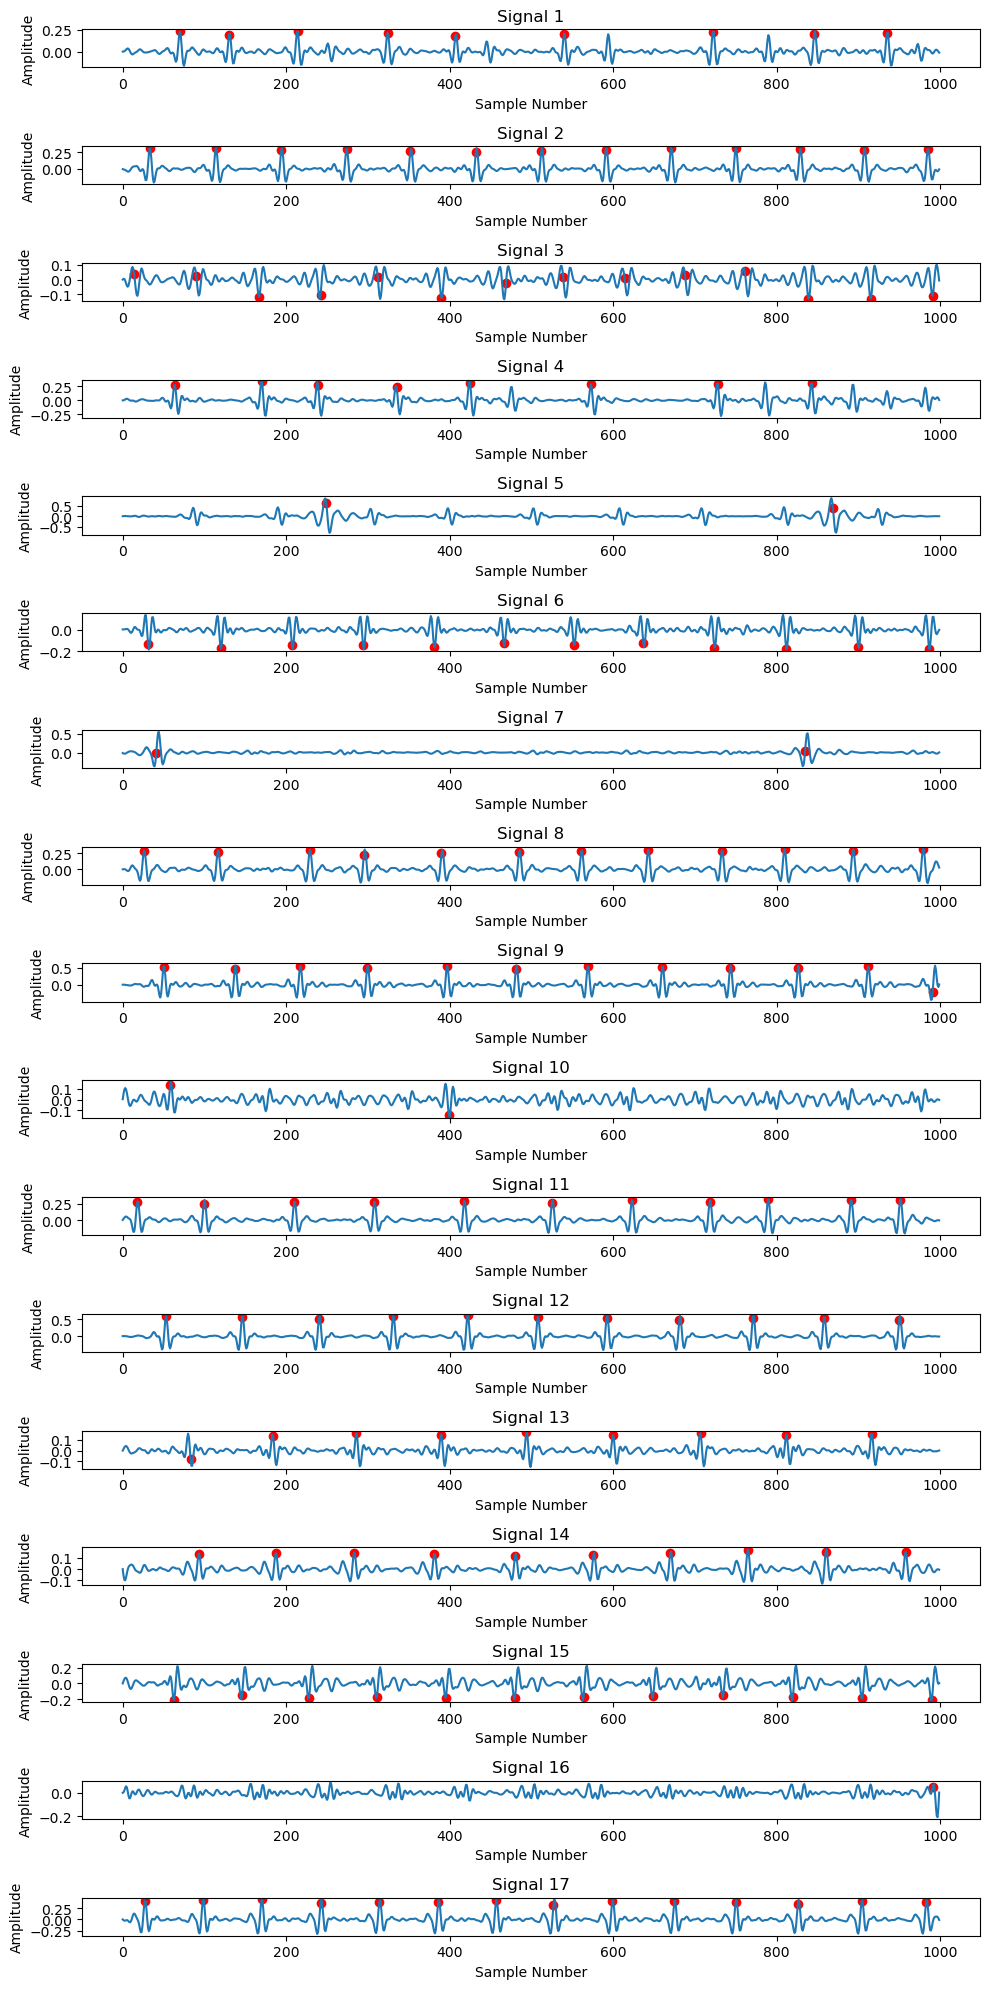

In [40]:
plot_signals(filtered_signals, r_peaks_all_signals)

<span style="color: red; font-size: 150%;">Signal Before Bandpass Filter</span>

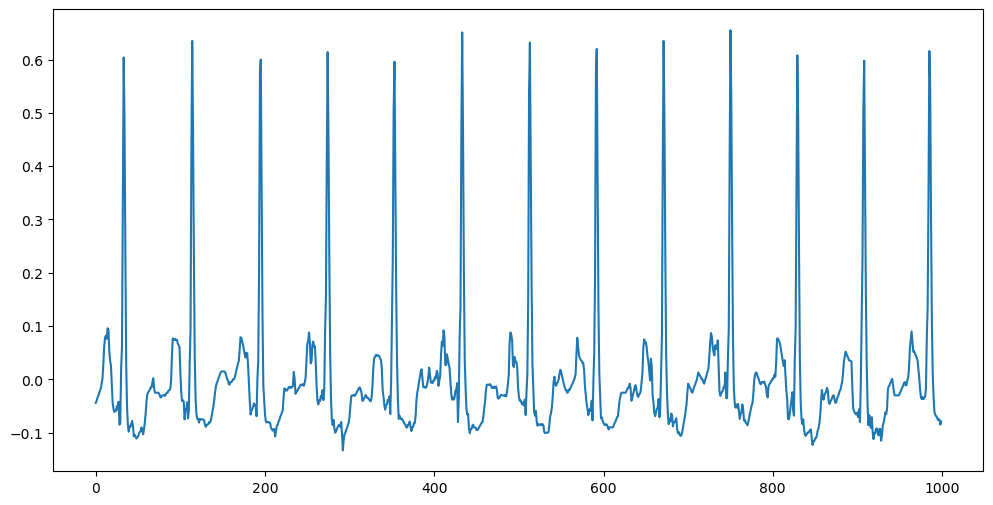

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(X[1, :, 0])
plt.show()

<span style="color: red; font-size: 150%;">Effect of the Bandpass Filter</span>

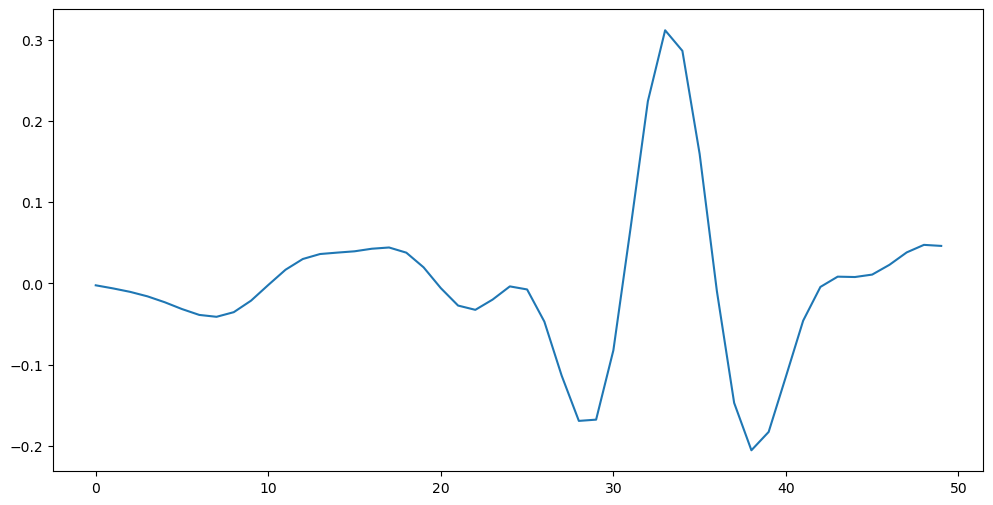

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(filtered_signals[1, :50, 0])
plt.show()

### Applying the remaining steps of the Pan-Tompkins Algorithm

In [20]:
# Initialize arrays for each step
derivative = np.zeros_like(filtered_signals)
squared = np.zeros_like(filtered_signals)
integrated = np.zeros_like(filtered_signals)

n_signals, n_samples, _ = filtered_signals.shape
window_size = int(0.150 * fs)  # 150 ms window

for i in range(n_signals):
    # Derivative
    derivative[i, :-1, 0] = np.diff(filtered_signals[i, :, 0])

    # Squaring
    squared[i, :, 0] = np.square(derivative[i, :, 0])

    # Moving window integration
    integrated[i, :, 0] = np.convolve(squared[i, :, 0], np.ones(window_size), mode='same')


<span style="color: red; font-size: 150%;">$\text{After applying Derivative Filter, Squaring, Integration}$</span>

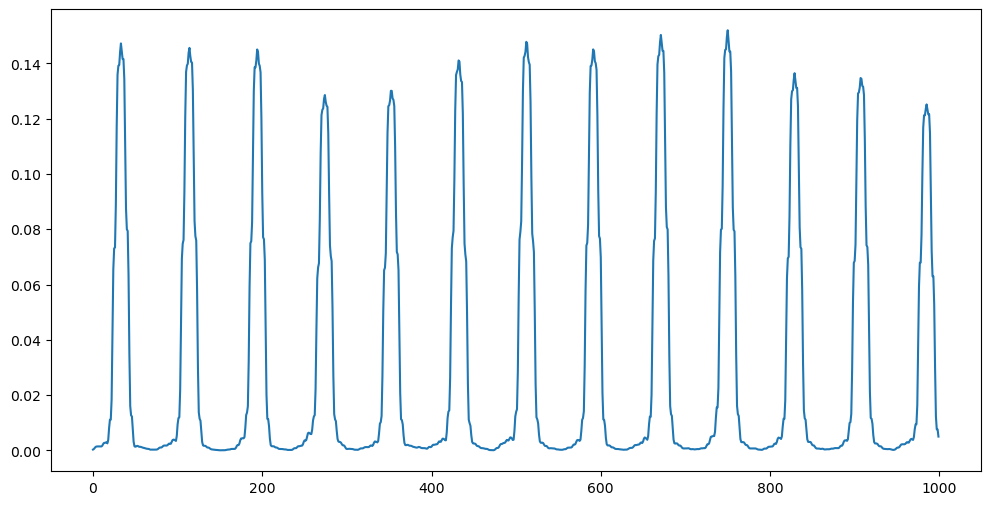

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(integrated[1, :, 0])
plt.show()

### Peak Detection

In [23]:
# initialize a list to store the R-peaks for each signal
r_peaks_all_signals = []

for i in range(n_signals):
    # find peaks on the integrated signal
    peaks, _ = find_peaks(integrated[i, :, 0], height=np.max(integrated[i, :, 0])*0.5, distance=fs*0.6)

    # Append the detected peaks to the list
    r_peaks_all_signals.append(peaks)

In [28]:
r_peaks_all_signals

[array([ 70, 130, 214, 324, 407, 540, 722, 846, 935], dtype=int64),
 array([ 33, 114, 194, 274, 352, 432, 512, 591, 671, 750, 829, 907, 985],
       dtype=int64),
 array([ 14,  90, 167, 242, 312, 390, 469, 539, 614, 688, 761, 839, 915,
        991], dtype=int64),
 array([ 64, 170, 239, 335, 425, 573, 728, 843], dtype=int64),
 array([249, 869], dtype=int64),
 array([ 31, 120, 207, 294, 381, 466, 552, 637, 724, 812, 900, 987],
       dtype=int64),
 array([ 41, 835], dtype=int64),
 array([ 26, 116, 229, 295, 390, 485, 561, 643, 733, 810, 893, 979],
       dtype=int64),
 array([ 50, 137, 217, 299, 397, 481, 569, 660, 743, 826, 912, 991],
       dtype=int64),
 array([ 58, 399], dtype=int64),
 array([ 18,  99, 210, 308, 418, 525, 623, 718, 790, 891, 951], dtype=int64),
 array([ 53, 146, 240, 331, 422, 508, 592, 681, 771, 858, 950], dtype=int64),
 array([ 83, 184, 286, 390, 494, 600, 707, 812, 917], dtype=int64),
 array([ 93, 187, 283, 381, 480, 576, 670, 765, 860, 958], dtype=int64),
 array(

### Extracting ST Segments

In [33]:
def extract_st_segments(ecg_signals, r_peaks_all, fs, st_duration=0.08, st_start_offset=0.06):
    """
    Extracts the ST segments from multiple ECG signals.

    :param ecg_signals: List of ECG signals, each being a 1D numpy array.
    :param r_peaks_all: 2D list of R-peaks indices for each ECG signal.
    :param fs: Sampling frequency of the ECG signals.
    :param st_duration: Duration of the ST segment in seconds (default is 80 ms).
    :param st_start_offset: Offset from the R-peak to start of ST segment in seconds (default is 60 ms).
    :return: 2D list of ST segment mean values for each individual.
    """

    all_st_segments = []

    for i, ecg_signal in enumerate(ecg_signals):
        st_segments = []
        for r_peak in r_peaks_all[i]:
            # calculate start and end indices of the ST segment
            st_start = int(r_peak + st_start_offset * fs)
            st_end = int(st_start + st_duration * fs)

            # ensure that the end index does not exceed the signal length
            if st_end > len(ecg_signal):
                continue

            # extracting the ST segment
            st_segment = ecg_signal[st_start:st_end]

            # calculate a feature of the ST segment, e.g., mean amplitude
            st_feature = np.mean(st_segment)
            st_segments.append(st_feature)
        
        all_st_segments.append(st_segments)

    return all_st_segments


<span style="color: blue; font-size: 120%;">$\text{We extract multiple ST segment mean value for each subject since there are multiple ST segments in each ECG signal}$</span>

In [34]:
st_segment_features =[]
for i in range(n_signals):
    # find peaks on the integrated signal
    st_segment_feature = extract_st_segments(filtered_signals, r_peaks_all_signals, 100)

    # Append the detected peaks to the list
    st_segment_features.append(st_segment_feature)

In [93]:
st_segment_features

[[[-0.01755188342051319,
   -0.028543619726060936,
   -0.014717303184815213,
   -0.01728061586468184,
   -0.02858482453706666,
   -0.025498583552691134,
   -0.030544442307535048,
   -0.033981592016839604,
   -0.026608268572031635],
  [-0.037234022919135565,
   -0.03706499315603138,
   -0.051335015465424724,
   -0.037491532924208426,
   -0.05598267452974119,
   -0.06399592681018942,
   -0.06244560795521757,
   -0.05612777085314198,
   -0.038474882654164724,
   -0.0396269836120413,
   -0.04165259658854565,
   -0.06004295782073285,
   -0.053524373341134905],
  [0.03281144780806597,
   0.03275596089002802,
   0.004681777593678556,
   -0.005124253299722693,
   0.04080001966343462,
   0.013552324829257193,
   -0.015157946897011818,
   0.037884661467013345,
   0.037488049689997305,
   0.03264634360715764,
   0.027916946484557583,
   0.01569607725873663,
   0.00767955483837455],
  [0.018009532469385987,
   -2.1183889621974317e-05,
   0.027795154314630442,
   0.025535732433097286,
   0.01491882

In [89]:
def calculate_feature_mean(input_list, feature_name):
    feature_averages = []

    # Iterate through qrs_areas and find the size of each sublist
    for sublist in input_list:
        feature_average = sum(sublist) / len(sublist) if len(sublist) > 0 else 0  # Calculate the average
        feature_averages.append(feature_average)

    for i, average in enumerate(feature_averages):
        print(f"Average of {feature_name} in ECG {i + 1}: {average}")

In [94]:
#calculate_feature_mean(st_segment_features, 'ST Segments')

### Extracting the QRS Features

In [73]:
def find_q_point(signal, r_peak, window_size):
    for i in range(r_peak, r_peak - window_size, -1):
        if i == 0:
            return 0
        if signal[i] > signal[i-1]:  # detecting the change in slope
            return i
    return r_peak - window_size

def find_s_point(signal, r_peak, window_size):
    for i in range(r_peak, r_peak + window_size):
        if i == len(signal) - 1:
            return len(signal) - 1
        if signal[i] > signal[i+1]:  # detecting the change in slope
            return i
    return r_peak + window_size

def extract_qrs_features(ecg_signals, r_peaks, window_size=20):  # window_size depends on fs=100Hz
    qrs_durations = []
    qrs_areas =[]
    for i, signal in enumerate(ecg_signals):
        qrs_duration = []
        qrs_area=[]
        for r_peak in r_peaks[i]:
            q_point = find_q_point(signal, r_peak, window_size)
            s_point = find_s_point(signal, r_peak, window_size)

            qrs_dur = s_point - q_point

            # Area under the curve
            qrs_area_value = np.trapz(signal[q_point:s_point+1], dx=1, axis=0)
            
            qrs_duration.append(qrs_dur)
            qrs_area.append(qrs_area_value)
            
        qrs_durations.append(qrs_duration)
        qrs_areas.append(qrs_area)
    return qrs_durations, qrs_areas

#### not sure if the qrs_areas are correct

In [74]:
qrs_durations, qrs_areas = extract_qrs_features(filtered_signals, r_peaks_all_signals)  # window size is 20 samples

### QRS durations for the each R peak detected in the ECG signal for all subjects:

In [75]:
qrs_durations

[[0, 1, 0, 0, 1, 0, 1, 1, 1],
 [0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0],
 [2, 2, 10, 4, 2, 10, 3, 2, 3, 2, 1, 10, 10, 10],
 [0, 0, 1, 1, 1, 0, 0, 0],
 [1, 2],
 [3, 9, 3, 3, 4, 3, 9, 3, 9, 9, 4, 9],
 [3, 3],
 [0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1],
 [0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 3],
 [1, 4],
 [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1],
 [0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1],
 [3, 1, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 1, 1, 1, 1, 0, 1, 0],
 [9, 4, 4, 4, 8, 4, 4, 4, 4, 4, 9, 4],
 [1],
 [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]]

In [91]:
calculate_feature_mean(qrs_durations, 'QRS Durations')

Average of QRS Durations in ECG 1: 0.5555555555555556
Average of QRS Durations in ECG 2: 0.46153846153846156
Average of QRS Durations in ECG 3: 5.071428571428571
Average of QRS Durations in ECG 4: 0.375
Average of QRS Durations in ECG 5: 1.5
Average of QRS Durations in ECG 6: 5.666666666666667
Average of QRS Durations in ECG 7: 3.0
Average of QRS Durations in ECG 8: 0.5833333333333334
Average of QRS Durations in ECG 9: 0.75
Average of QRS Durations in ECG 10: 2.5
Average of QRS Durations in ECG 11: 0.36363636363636365
Average of QRS Durations in ECG 12: 0.6363636363636364
Average of QRS Durations in ECG 13: 0.5555555555555556
Average of QRS Durations in ECG 14: 0.5
Average of QRS Durations in ECG 15: 5.166666666666667
Average of QRS Durations in ECG 16: 1.0
Average of QRS Durations in ECG 17: 0.7857142857142857


In [90]:
calculate_feature_mean(qrs_areas, 'QRS Areas')

Average of QRS Areas in ECG 1: [0.11581295]
Average of QRS Areas in ECG 2: [0.1353662]
Average of QRS Areas in ECG 3: [0.02601975]
Average of QRS Areas in ECG 4: [0.10686544]
Average of QRS Areas in ECG 5: [1.04976222]
Average of QRS Areas in ECG 6: [-0.04229744]
Average of QRS Areas in ECG 7: [1.05896664]
Average of QRS Areas in ECG 8: [0.16830102]
Average of QRS Areas in ECG 9: [0.32014135]
Average of QRS Areas in ECG 10: [0.12234767]
Average of QRS Areas in ECG 11: [0.10446768]
Average of QRS Areas in ECG 12: [0.35469918]
Average of QRS Areas in ECG 13: [0.05475101]
Average of QRS Areas in ECG 14: [0.07127255]
Average of QRS Areas in ECG 15: [0.10930227]
Average of QRS Areas in ECG 16: [0.05887796]
Average of QRS Areas in ECG 17: [0.32065186]


### The below cell will be tested later

In [ ]:
# Split data into train and test
test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass